In [57]:
%matplotlib inline
import pylab as pl
from astropy import units as u, constants, visualization
visualization.quantity_support()
pl.style.use('dark_background')

# Observation Planning to Map Making

AST 4723

In this lecture, we'll go through how you can use the observation planning tools you've already used to place your observations onto maps of the Milky Way.

This material will serve as part of your lab writeup to show what you ended up looking at.  It's especially important if you missed your target!

This is also how we'll end up making maps (or images) of our data, especially the drift scans, for the final project.

We start by setting up an Observer - Gainesville - using astroplan:

(`from_geodetic` allows you to specify the altitude above the Earth's approximated surface; `from_geocentric` would let you specify distance from Earth's center)

In [58]:
from astroplan import Observer
from astropy import units as u, coordinates
location = coordinates.EarthLocation.from_geodetic(-82.3*u.deg, 29.6*u.deg, 100*u.m)
observer = Observer(location, timezone='US/Eastern')
observer

<Observer: location (lon, lat, el)=(-82.3 deg, 29.60000000000001 deg, 100.00000000121652 m),
    timezone=<DstTzInfo 'US/Eastern' LMT-1 day, 19:04:00 STD>>

Now let's load some data. You can list your data by using `ls <directoryname>`, for example.

(on windows, you might need to do `import os; os.listdir(<directoryname>)`)

In [59]:
ls data/

driftscan/
psd_200725_100309_tint60s_sdr0_fsw.fits*
psd_200805_085031_tint60s_sdr0_fsw.fits
psd_200918_140757_tint60s_sdr0_fsw50ohm_on_calibration_60s.fits


In [60]:
from astropy.table import Table
datatable = Table.read('data/psd_200725_100309_tint60s_sdr0_fsw.fits')

We can plot it up to see what data we're working with:

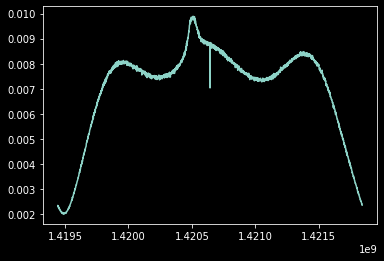

In [61]:
pl.plot(datatable['freq1'], datatable['power1'])

Or, if we want to inspect the frequency-switched data:

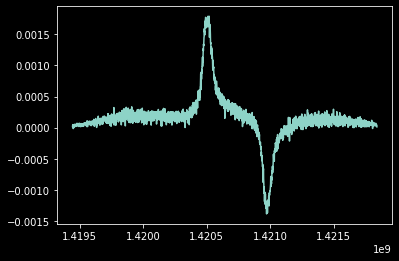

In [62]:
pl.plot(datatable['freq1'], datatable['power1']-datatable['power2'])

The files we've created have _metadata_ that tell us where there telescope was pointed and when it was pointed there.

Remember, though, that the altitude and azimuth were numbers we measured and entered ourselves!

In [63]:
datatable.meta

OrderedDict([('--obs_lat', '29.6'),
             ('--obs_lon', '-82.3'),
             ('--altitude', '80'),
             ('--azimuth', '180'),
             ('DATE-OBS', '200725_100309')])

We can actually create our observer from these data directly:

In [64]:
obslon = float(datatable.meta['--obs_lon']) * u.deg
obslat = float(datatable.meta['--obs_lat']) * u.deg
location = coordinates.EarthLocation.from_geodetic(obslon, obslat, 100*u.m)
observer = Observer(location, timezone='US/Eastern')

We need to load the date as a `datetime` object:

In [65]:
import datetime
obs_time_notz = datetime.datetime.strptime(datatable.meta['DATE-OBS'], "%y%m%d_%H%M%S")
obs_time_notz

datetime.datetime(2020, 7, 25, 10, 3, 9)

This datetime is in local time, which is eastern time.

You can tell by looking at the source code of our data recording script:
https://github.com/keflavich/1420SDR/blob/master/1420_psd.py#L207
`    now = str(datetime.datetime.now().strftime("%y%m%d_%H%M%S"))`

This line also contains the appropriate [string formatting codes](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes).

We have to "localize" this time, otherwise it gets interpreted as UTC (Universal Coordinated Time).

In [66]:
import pytz
tz = pytz.timezone('US/Eastern')
obs_time = tz.localize(obs_time_notz)
obs_time

datetime.datetime(2020, 7, 25, 10, 3, 9, tzinfo=<DstTzInfo 'US/Eastern' EDT-1 day, 20:00:00 DST>)

Now we can create an `AltAz` target for our observation:

In [67]:
alt = float(datatable.meta['--altitude'])
az = float(datatable.meta['--azimuth'])
target_altaz = coordinates.AltAz(alt=alt*u.deg,
                                 az=az*u.deg,
                                 location=observer.location,
                                 obstime=obs_time)
target_altaz

<AltAz Coordinate (obstime=2020-07-25 14:03:09, location=(743674.13504562, -5500332.52750589, 3131946.80724394) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (180., 80.)>

Note that the time *changed* when we loaded it with the observer!  The `AltAz` coordinate object forces the "time" into UTC (Universal Coordinated Time).  

This is important!  If you have the time wrong, you'll be off by many hours (each hour is 15 degrees)!

With the altaz object, we can now find out where we were pointing:

In [68]:
target_icrs = target_altaz.transform_to(coordinates.ICRS)
target_icrs

<ICRS Coordinate: (ra, dec) in deg
    (71.93099208, 19.56556397)>

In [69]:
target_galactic = target_altaz.transform_to(coordinates.Galactic)
target_galactic

<Galactic Coordinate: (l, b) in deg
    (180.23358104, -16.15940703)>

# Make an Image to plot on...

The next step is going to require a bit of work, but it can mostly be copy-pasted.

We're going to make an image of the whole Galaxy from archival data!

https://docs.astropy.org/en/stable/visualization/wcsaxes/custom_frames.html has more details

In [70]:
# we need to import more packages!
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.visualization import simple_norm

In [71]:
# first step: we need to download an all-sky image
# Use the ROSAT image to get an all-sky header
filename = get_pkg_data_filename('allsky/allsky_rosat.fits')
hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)
data = hdu.data

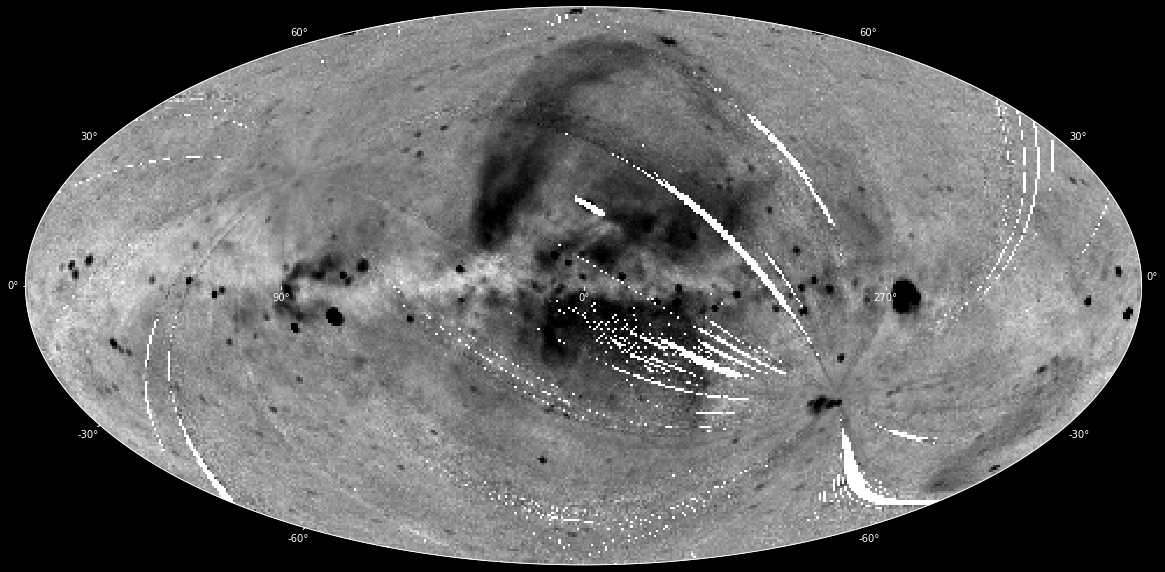

In [72]:
# next, make the figure with special attributes
pl.figure(figsize=(20,15))
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
im = ax.imshow(data, origin='lower', cmap='gray_r', interpolation='none',
               norm=simple_norm(data, stretch='asinh', max_percent=99.5, min_percent=1))

Now that we have this Galactic plot, we can show where we looked!

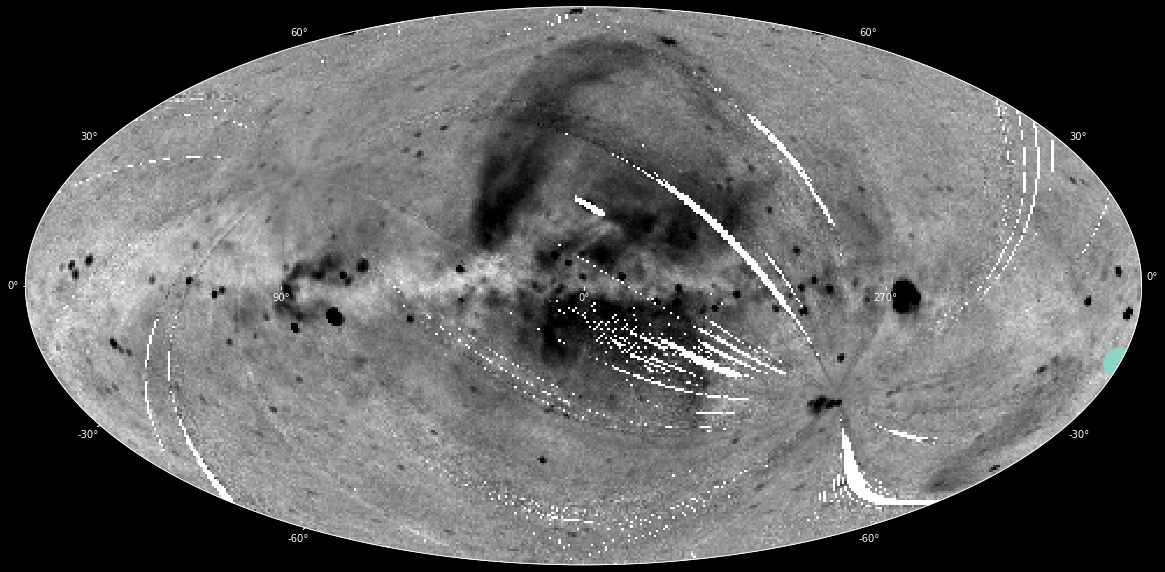

In [73]:
pl.figure(figsize=(20,15))
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
im = ax.imshow(data, origin='lower', cmap='gray_r', interpolation='none',
               norm=simple_norm(data, stretch='asinh', max_percent=99.5, min_percent=1))
ax.scatter(target_galactic.l, target_galactic.b, s=1000, transform=ax.get_transform('galactic'))

We'd like to be able to plot the appropriate "footprint" on the image, but there's a bit of a [bug](https://github.com/astropy/astropy/issues/10780)...

In [74]:
beamsize = (1.22*21*u.cm/(1.5*u.m)).to(u.deg, u.dimensionless_angles())

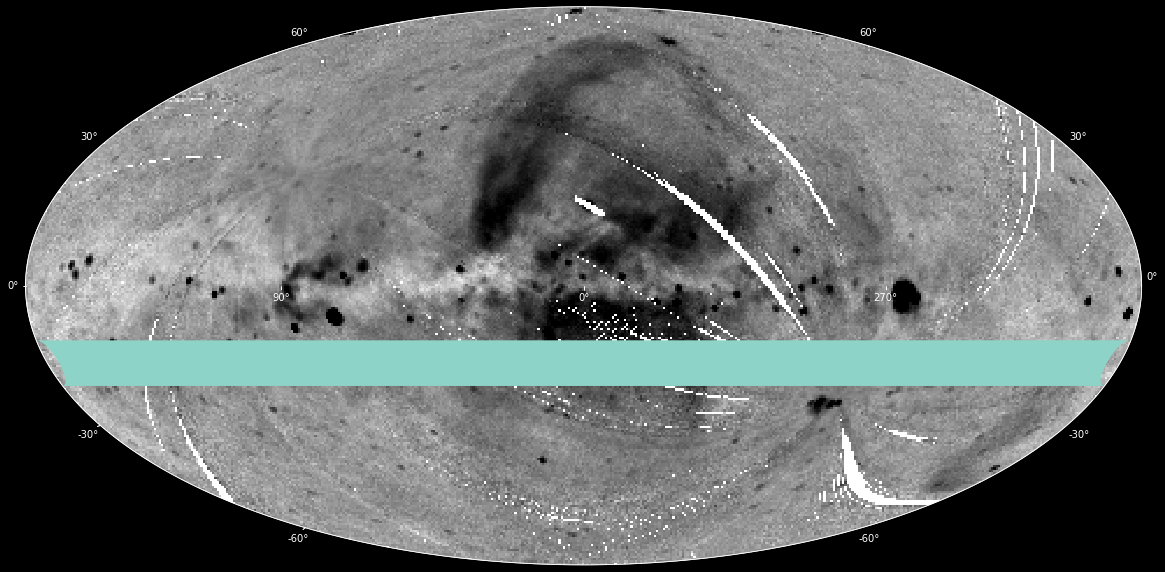

In [75]:
from astropy.visualization.wcsaxes import SphericalCircle
pl.figure(figsize=(20,15))
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
im = ax.imshow(data, origin='lower', cmap='gray_r', interpolation='none',
               norm=simple_norm(data, stretch='asinh', max_percent=99.5, min_percent=1))
circle = SphericalCircle((target_galactic.l, target_galactic.b),
                         radius=beamsize/2,
                         transform=ax.get_transform('galactic'))
ax.add_patch(circle)

We can also get the location of the sun and see how close it was to where we were pointed:

*POLL QUESTION*

In [76]:
sun_loc = observer.sun_altaz(time=obs_time)
sun_loc_gal = sun_loc.transform_to(coordinates.Galactic)
sun_loc_gal

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, m)
    (207.74690436, 33.23223007, 1.30796065e+09)>

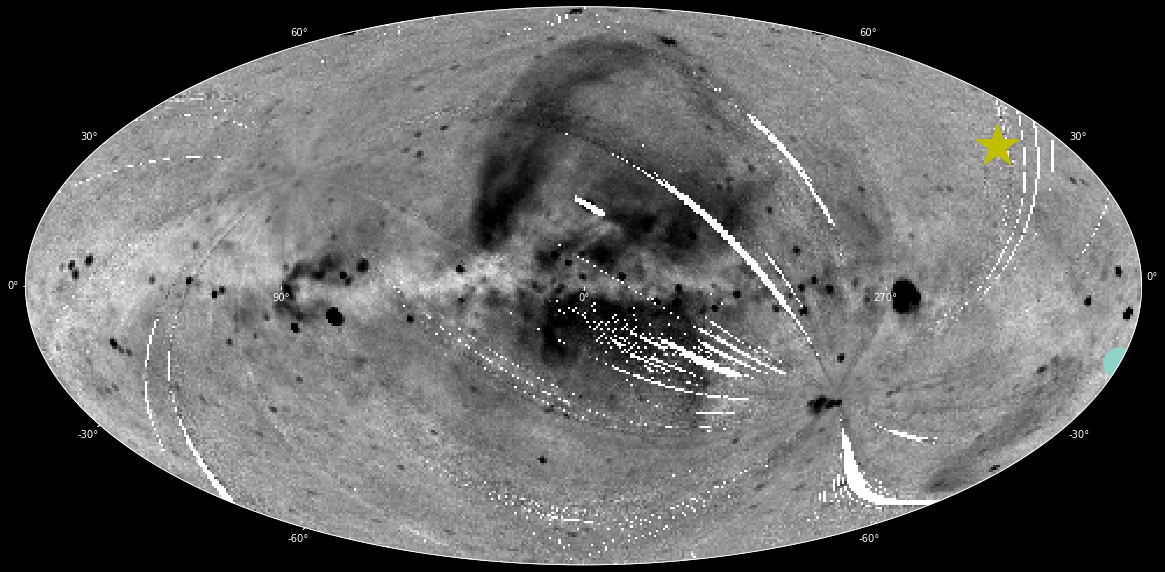

In [77]:
pl.figure(figsize=(20,15))
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
im = ax.imshow(data, origin='lower', cmap='gray_r', interpolation='none',
               norm=simple_norm(data, stretch='asinh', max_percent=99.5, min_percent=1))
ax.scatter(target_galactic.l, target_galactic.b, s=1000, transform=ax.get_transform('galactic'))
ax.scatter(sun_loc_gal.l, sun_loc_gal.b, s=2000, marker='*', c='y', transform=ax.get_transform('galactic'))

Let's look at one more pointing...

In [78]:
datatable2 = Table.read('data/psd_200805_085031_tint60s_sdr0_fsw.fits')
datatable2.meta

OrderedDict([('--obs_lat', '29.6'),
             ('--obs_lon', '-82.3'),
             ('--altitude', '44'),
             ('--azimuth', '180'),
             ('DATE-OBS', '200805_085031')])

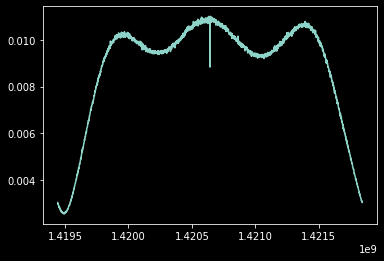

In [79]:
pl.plot(datatable2['freq1'], datatable2['power1'])

In [80]:
alt2 = float(datatable2.meta['--altitude'])
az2 = float(datatable2.meta['--azimuth'])
obs_time2 = tz.localize(
    datetime.datetime.strptime(datatable2.meta['DATE-OBS'],
                               "%y%m%d_%H%M%S"))
target_altaz2 = coordinates.AltAz(alt=alt2*u.deg,
                                  az=az2*u.deg,
                                  location=observer.location,
                                  obstime=obs_time2)
target_altaz2

<AltAz Coordinate (obstime=2020-08-05 12:50:31, location=(743674.13504562, -5500332.52750589, 3131946.80724394) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (180., 44.)>

In [81]:
target_galactic2 = target_altaz2.transform_to(coordinates.Galactic)
target_galactic2

<Galactic Coordinate: (l, b) in deg
    (211.52018746, -41.09479575)>

In [82]:
sun_loc2 = observer.sun_altaz(time=obs_time2)
sun_loc_gal2 = sun_loc2.transform_to(coordinates.Galactic)
sun_loc_gal2

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, m)
    (208.17881994, 33.75013696, 1.31052469e+09)>

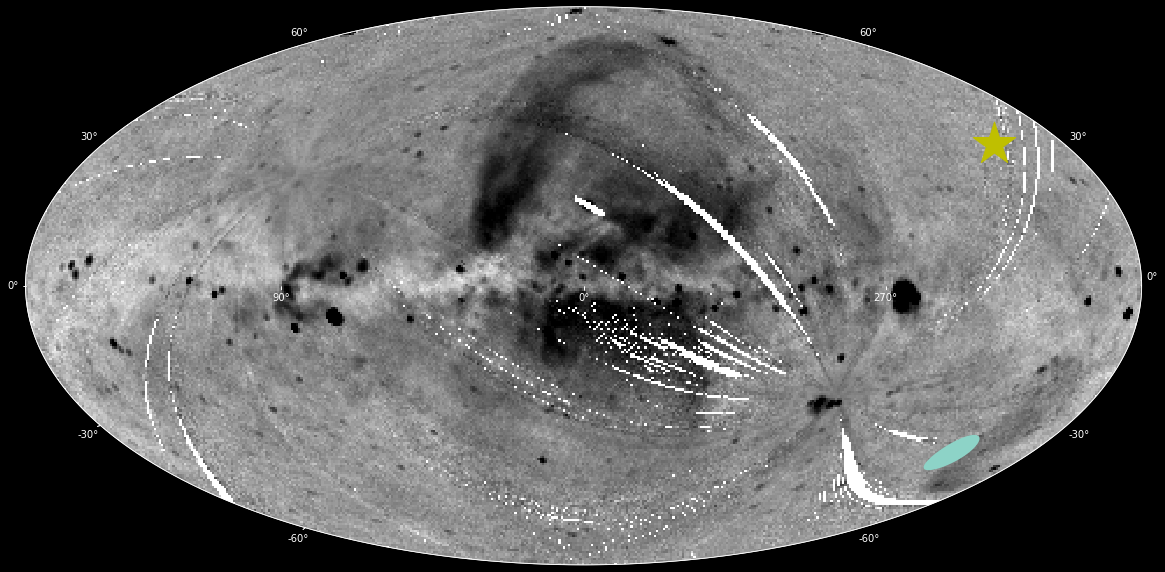

In [83]:
pl.figure(figsize=(20,15))
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
im = ax.imshow(data, origin='lower', cmap='gray_r', interpolation='none',
               norm=simple_norm(data, stretch='asinh', max_percent=99.5, min_percent=1))
circle = SphericalCircle((target_galactic2.l, target_galactic2.b),
                         radius=beamsize/2,
                         transform=ax.get_transform('galactic'))
ax.add_patch(circle)
ax.scatter(sun_loc_gal2.l, sun_loc_gal2.b, s=2000, marker='*', c='y', transform=ax.get_transform('galactic'))

We can overplot several different observations...

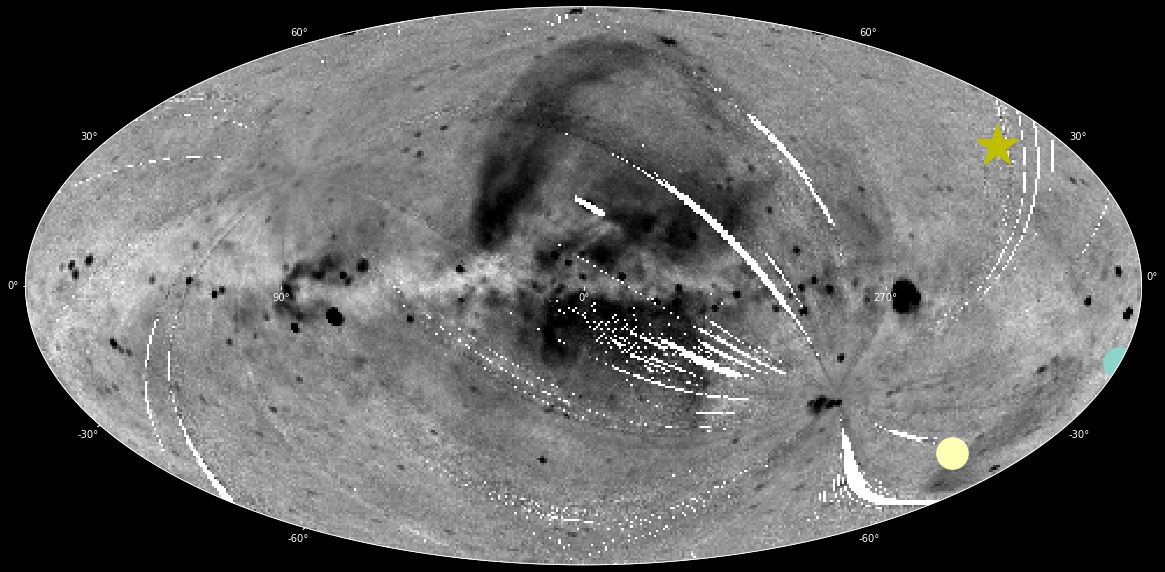

In [84]:
pl.figure(figsize=(20,15))
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
im = ax.imshow(data, origin='lower', cmap='gray_r', interpolation='none',
               norm=simple_norm(data, stretch='asinh', max_percent=99.5, min_percent=1))
ax.scatter(target_galactic.l, target_galactic.b, s=1000, transform=ax.get_transform('galactic'))
ax.scatter(target_galactic2.l, target_galactic2.b, s=1000, transform=ax.get_transform('galactic'))
ax.scatter(sun_loc_gal.l, sun_loc_gal.b, s=2000, marker='*', c='y', transform=ax.get_transform('galactic'))

You can also calculate a "drift scan track"

In [85]:
from datetime import timedelta
obstimes = [obs_time + timedelta(hours=ii) for ii in range(24)]
altazs = [coordinates.AltAz(180*u.deg, 45*u.deg,
                            location=observer.location,
                            obstime=ot)
          for ot in obstimes]
galcoords = [aa.transform_to(coordinates.Galactic)
             for aa in altazs]
galcoords = coordinates.SkyCoord(galcoords)
galcoords

<SkyCoord (Galactic): (l, b) in deg
    [(213.7235452 , -34.15449446), (220.09886232, -20.79432989),
     (226.35271326,  -7.61672364), (233.13460764,   5.20583761),
     (241.10266881,  17.42909731), (251.09944783,  28.65429544),
     (264.21753646,  38.19930318), (281.42226785,  44.96213259),
     (302.11630882,  47.57851901), (322.96228789,  45.31047223),
     (340.4748179 ,  38.80597483), (353.86690482,  29.42239136),
     (  4.05260691,  18.29335667), ( 12.1374604 ,   6.12790547),
     ( 18.98234877,  -6.65950635), ( 25.25373696, -19.81661705),
     ( 31.59375447, -33.16795473), ( 38.91870392, -46.54894763),
     ( 49.26238474, -59.69511485), ( 69.45276818, -71.77729073),
     (122.60799931, -78.38391791), (176.09911308, -71.86559112),
     (196.43672779, -59.80043479), (206.82166529, -46.6576499 )]>

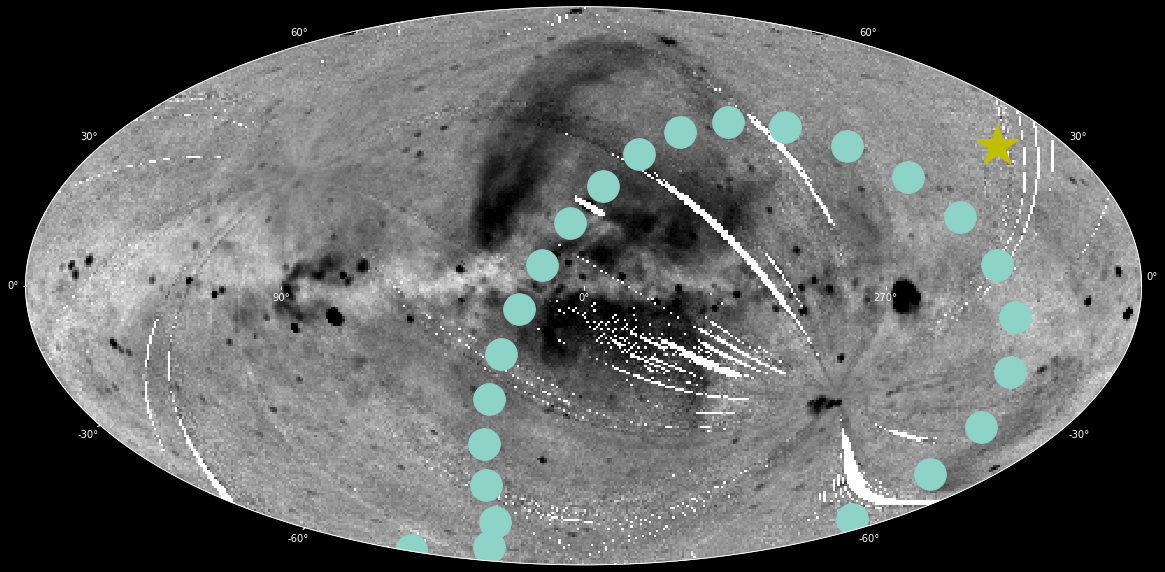

In [86]:
pl.figure(figsize=(20,15))
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
im = ax.imshow(data, origin='lower', cmap='gray_r', interpolation='none',
               norm=simple_norm(data, stretch='asinh', max_percent=99.5, min_percent=1))
ax.scatter(galcoords.l, galcoords.b, s=1000, transform=ax.get_transform('galactic'))
ax.scatter(sun_loc_gal.l, sun_loc_gal.b, s=2000, marker='*', c='y', transform=ax.get_transform('galactic'))

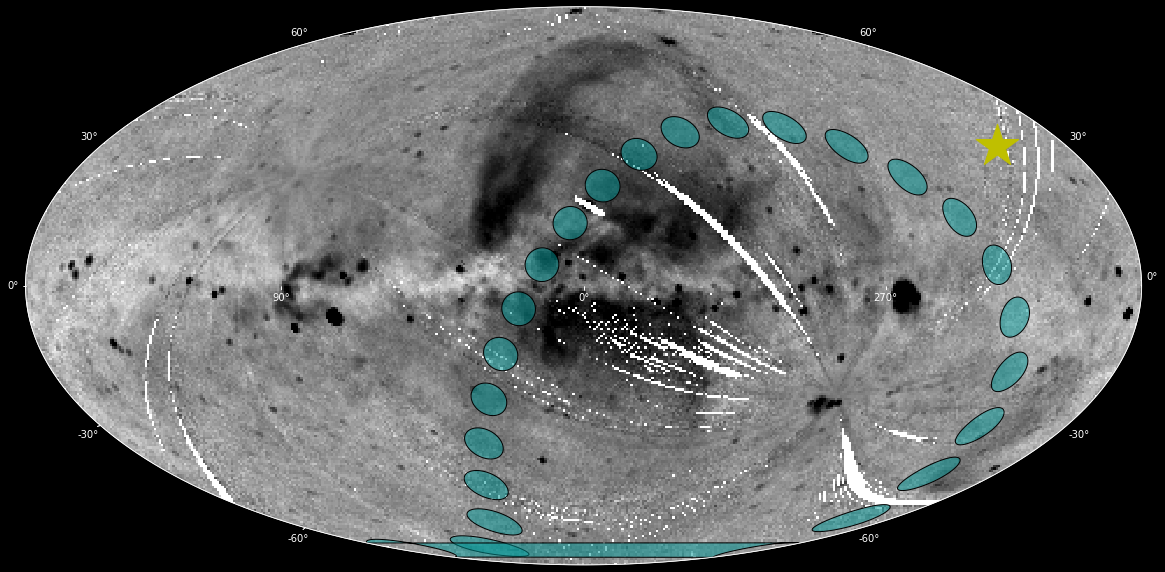

In [87]:
pl.figure(figsize=(20,15))
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
im = ax.imshow(data, origin='lower', cmap='gray_r', interpolation='none',
               norm=simple_norm(data, stretch='asinh', max_percent=99.5, min_percent=1))
ax.scatter(sun_loc_gal.l, sun_loc_gal.b, s=2000, marker='*', c='y', transform=ax.get_transform('galactic'))

for cc in galcoords:
    circ = SphericalCircle((cc.l, cc.b),
                           radius=beamsize/2,
                           facecolor=(0,0.6,0.6,0.5),
                           edgecolor='k',
                           transform=ax.get_transform('galactic'))
    ax.add_patch(circ)

One more trick: we can plot a different data set - an HI data set from another group - instead of the X-ray data:

In [88]:
from reproject import reproject_from_healpix, reproject_to_healpix
hihdu = fits.open('https://lambda.gsfc.nasa.gov/data/foregrounds/ebv_2017/mom0_-90_90_1024.hpx.fits')
array, footprint = reproject_from_healpix(hihdu[1], hdu.header)

/home/adam/anaconda3/lib/python3.7/site-packages/astropy_healpix/core.py:516: RuntimeWarning: invalid value encountered in bilinear_interpolation_weights
  result = _core.bilinear_interpolation_weights(lon, lat, nside)


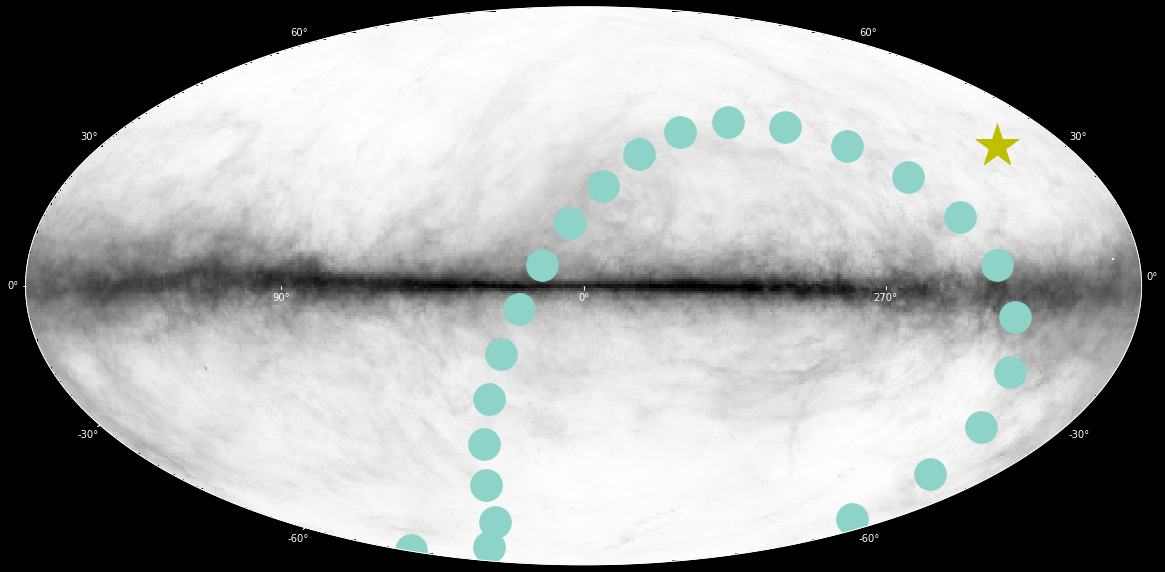

In [89]:
pl.figure(figsize=(20,15))
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
im = ax.imshow(array, origin='lower', cmap='gray_r', interpolation='none',
               norm=simple_norm(array, stretch='asinh', max_percent=99.95,))
ax.scatter(galcoords.l, galcoords.b, s=1000, transform=ax.get_transform('galactic'))
ax.scatter(sun_loc_gal.l, sun_loc_gal.b, s=2000, marker='*', c='y', transform=ax.get_transform('galactic'))

Is there anything else we might want to look at?  Maybe the Moon and Andromeda...

In [90]:
moon_altaz = observer.moon_altaz(time=obs_time)
moon_gal = moon_altaz.transform_to(coordinates.Galactic)
moon_gal

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, m)
    (24.04115377, -27.86293913, 1.50488663e+11)>

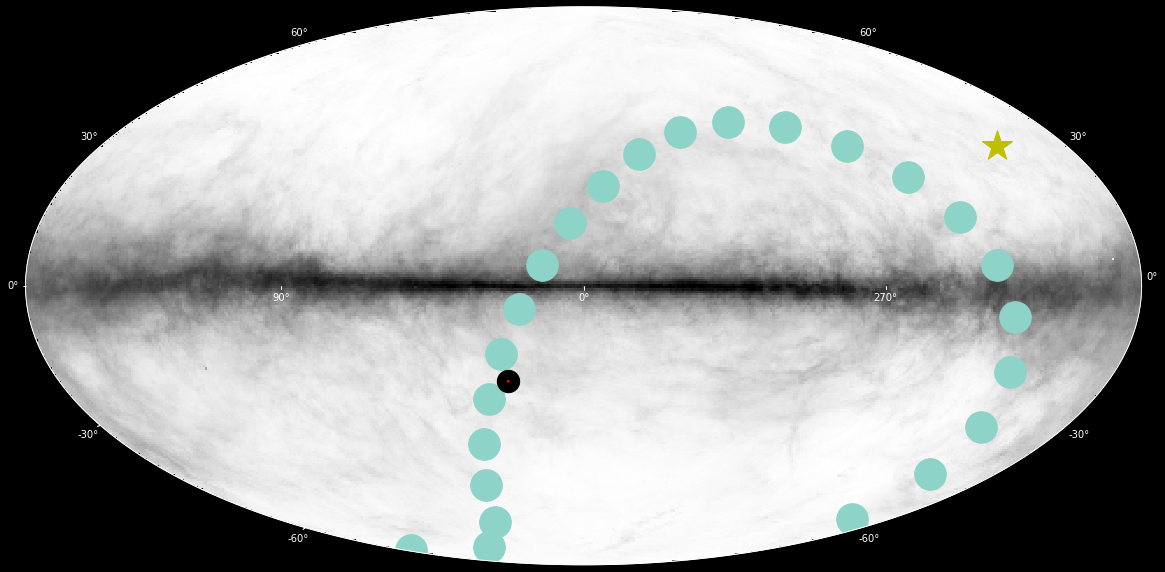

In [92]:
pl.figure(figsize=(20,15))
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
im = ax.imshow(array, origin='lower', cmap='gray_r', interpolation='none',
               norm=simple_norm(array, stretch='asinh', max_percent=99.95,))
ax.scatter(galcoords.l, galcoords.b, s=1000, transform=ax.get_transform('galactic'))
ax.scatter(sun_loc_gal.l, sun_loc_gal.b, s=1000, marker='*', c='y', transform=ax.get_transform('galactic'))
ax.scatter(moon_gal.l, moon_gal.b, s=500, marker='o', c='k', transform=ax.get_transform('galactic'))
circle = SphericalCircle((moon_gal.l, moon_gal.b), radius=0.25*u.deg, color='r',
                         transform=ax.get_transform('galactic'))
ax.add_patch(circle)

In [93]:
andromeda = coordinates.SkyCoord.from_name("M31").galactic

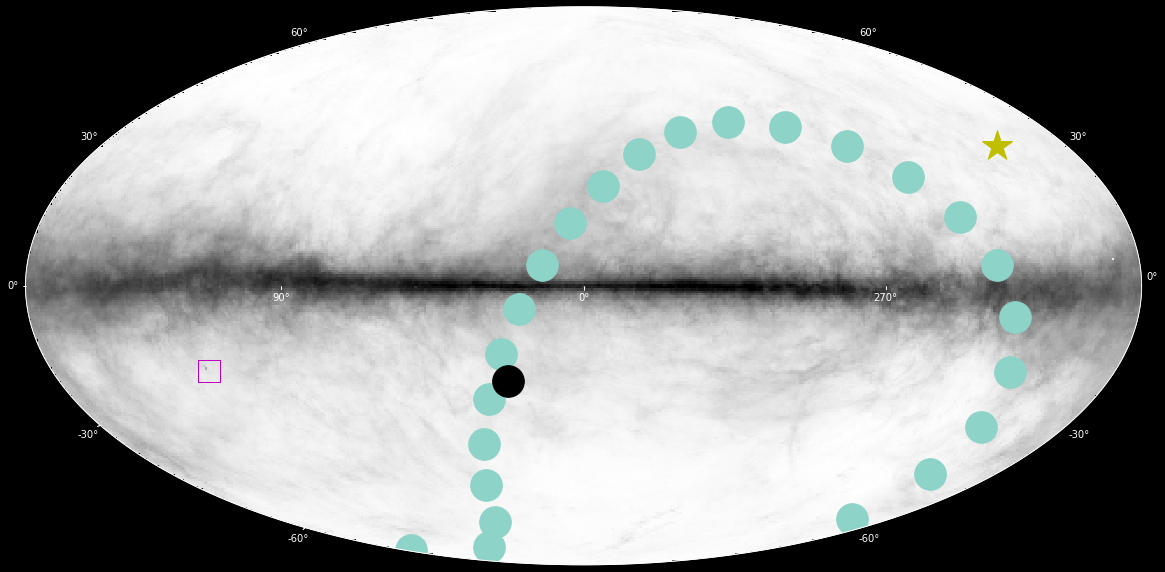

In [94]:
pl.figure(figsize=(20,15))
ax = pl.subplot(projection=wcs, frame_class=EllipticalFrame)
im = ax.imshow(array, origin='lower', cmap='gray_r', interpolation='none',
               norm=simple_norm(array, stretch='asinh', max_percent=99.95,))
ax.scatter(galcoords.l, galcoords.b, s=1000, transform=ax.get_transform('galactic'))
ax.scatter(sun_loc_gal.l, sun_loc_gal.b, s=1000, marker='*', c='y', transform=ax.get_transform('galactic'))
ax.scatter(moon_gal.l, moon_gal.b, s=1000, marker='o', c='k', transform=ax.get_transform('galactic'))
ax.scatter(andromeda.l, andromeda.b, s=500, marker='s', edgecolor='m', facecolor='none', transform=ax.get_transform('galactic'))

# Making our own maps

Once we have a bunch of observations at different locations, how can we turn them into an image?

Let's start out with our actual measurements: we measure the *integrated intensity* of the line, the *centroid* of the line, and its *width*.

We can *grid* these.

# Gridding

When gridding data, we first have to establish a grid.

A good rule-of-thumb is that the grid should Nyquist sample the beam: there should be >2 pixels per beam-width.

For an all-sky survey, this is kind of tricky because you can't represent the sky, which is a sphere, as a rectangle fairly.

# HEALpix

If we want to be really careful about spherical projection effects, we use [Hierarchical Equal Area isoLatitude Pixelation](https://healpix.jpl.nasa.gov/); cosmologists use this.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/12/HEALPix_projection_SW.svg/600px-HEALPix_projection_SW.svg.png">

# Approximations...

In practice, we expect to detect most or all of the HI we see near the Galactic midplane, where we can reasonable approximate each pixel as square.

https://reproject.readthedocs.io/en/stable/healpix.html is the place to go to get things more correct.

So what's a reasonable grid to use?

Our beam is FWHM~9 deg, so we need ~4.5 deg pixels.  We therefore need (360/4.5) by (180/4.5) pixels

In [95]:
grid_lon = np.linspace(-180, 180, int(360/4.5))*u.deg
grid_lat = np.linspace(-90, 90, int(180/4.5))*u.deg
len(grid_lon), len(grid_lat)

(80, 40)

In [96]:
# grid is y,x
grid = np.zeros([len(grid_lat), len(grid_lon)])

We can now take our observations and turn them into "total intensity" observations by summing their power

(14.408606296222755, 18.085194243506113)

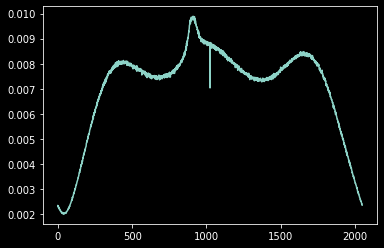

In [97]:
pl.plot(datatable['power1'])
sum1 = datatable['power1'].sum()
sum2 = datatable2['power1'].sum()
sum1, sum2


(you'll want to do this with other measurements, i.e., the moments, rather than total intensity - this example is to demonstrate the method)

The first approach we'll try is the *nearest neighbor* approach: we just find the pixel whose center is closest to the target.

In [98]:
xpix = np.argmin( np.abs(target_galactic.l.wrap_at(180*u.deg) - grid_lon) )
ypix = np.argmin( np.abs(target_galactic.b - grid_lat) )
xpix,ypix

(0, 16)

What's `wrap_at`?  Our longitude grid goes from -180 to 180, but the default representation of Galactic coordinates is 0 to 360.  We can change that by changing the point where the circle wraps to negative numbers.

In [99]:
target_galactic.l, target_galactic.l.wrap_at(180*u.deg)

(<Longitude 180.23358104 deg>, <Angle -179.76641896 deg>)

In [100]:
# add our data value at the nearest-neighbor pixel number
grid[ypix,xpix] += sum1

Do it again for another target location

In [101]:
xpix2 = np.argmin( np.abs(target_galactic2.l.wrap_at(180*u.deg) - grid_lon) )
ypix2 = np.argmin( np.abs(target_galactic2.b - grid_lat) )
xpix2,ypix2

(7, 11)

In [102]:
grid[ypix2,xpix2] += sum2

Now we can look at our resulting map, with 2 pixels containing data.

Text(0, 0.5, 'Galactic Latitude')

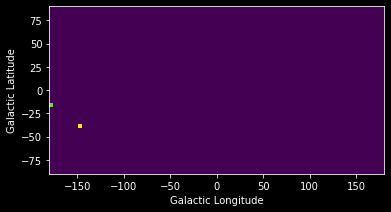

In [103]:
pl.imshow(grid, extent=[-180, 180, -90, 90], origin='lower')
pl.xlabel("Galactic Longitude")
pl.ylabel("Galactic Latitude")

Our real goal is to do this with more than just two observations.

To do this, we'll need to load up some more data from a *drift scan* observation.

In [104]:
ls data/driftscan/ | wc

    127     127    6735


We have 127 files to load, so we'll automate that:

In [105]:
import glob
file_list = glob.glob('data/driftscan/psd*fits')

In [106]:
tables = [Table.read(fn) for fn in file_list]

Now we'll do some automation...

In [107]:
for tbl in tables:
    powsum = tbl['power1'].sum()
    alt = float(tbl.meta['--altitude'])
    az = float(tbl.meta['--azimuth'])
    ot = tz.localize(
        datetime.datetime.strptime(tbl.meta['DATE-OBS'],
                                   "%y%m%d_%H%M%S"))
    tgtaltaz = coordinates.AltAz(alt=alt*u.deg,
                                 az=az*u.deg,
                                 location=observer.location,
                                 obstime=ot)
    tgtgal = tgtaltaz.transform_to(coordinates.Galactic)

    xpix = np.argmin( np.abs(tgtgal.l.wrap_at(180*u.deg) - grid_lon) )
    ypix = np.argmin( np.abs(tgtgal.b - grid_lat) )
    grid[ypix,xpix] += powsum    

Text(0, 0.5, 'Galactic Latitude')

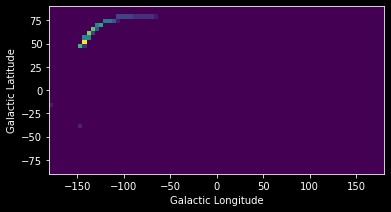

In [108]:
pl.imshow(grid, extent=[-180, 180, -90, 90], origin='lower')
pl.xlabel("Galactic Longitude")
pl.ylabel("Galactic Latitude")

We might have had multiple pixels land in the same location, though, so we did something wrong here: we need to *average* each pixel, not just sum it.

That requires a separate step.

In [109]:
grid = np.zeros([len(grid_lat), len(grid_lon)])
hitgrid = np.zeros([len(grid_lat), len(grid_lon)])

In [110]:
for tbl in tables:
    powsum = tbl['power1'].sum()
    alt = float(tbl.meta['--altitude'])
    az = float(tbl.meta['--azimuth'])
    ot = tz.localize(
        datetime.datetime.strptime(tbl.meta['DATE-OBS'],
                                   "%y%m%d_%H%M%S"))
    tgtaltaz = coordinates.AltAz(alt=alt*u.deg,
                                 az=az*u.deg,
                                 location=observer.location,
                                 obstime=ot)
    tgtgal = tgtaltaz.transform_to(coordinates.Galactic)

    xpix = np.argmin( np.abs(tgtgal.l.wrap_at(180*u.deg) - grid_lon) )
    ypix = np.argmin( np.abs(tgtgal.b - grid_lat) )
    grid[ypix,xpix] += powsum
    hitgrid[ypix,xpix] += 1 # Note this new step!

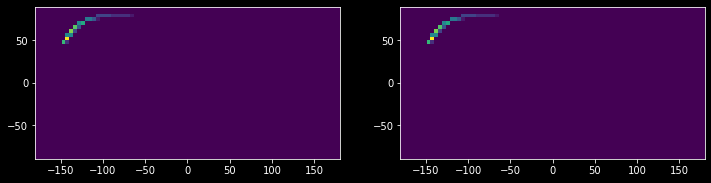

In [111]:
pl.figure(figsize=(12, 6))
pl.subplot(1,2,1).imshow(grid, extent=[-180, 180, -90, 90], origin='lower')
pl.subplot(1,2,2).imshow(hitgrid, extent=[-180, 180, -90, 90], origin='lower')

/home/adam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Galactic Latitude')

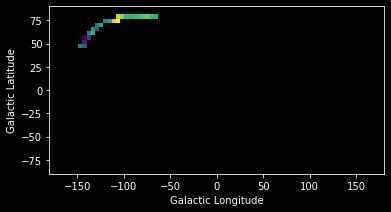

In [112]:
pl.imshow(grid / hitgrid, extent=[-180, 180, -90, 90], origin='lower')
pl.xlabel("Galactic Longitude")
pl.ylabel("Galactic Latitude")
# the warning below tells us we've divided by zero, getting NaNs - that's OK!  Those are "blank pixels"

With this approach, we can start to make an all-sky map!  This will be left for one of the final projects.

There are more caveats, of course.  Nearest-neighbor gridding is the fastest (computationally), but not the optimal approach.

The optimal approach is to grid using the beam - each measurement we make is sensitive to a Gaussian-like area on the sky, so each pixel has *some* nonzero contribution from each measurement, though for most pixels it's very close to zero.

We're not going to get into this in detail as a class, though.  You can find more information about the costs & benefits of different gridding choices in [The On The Fly Imaging Technique](https://www.aanda.org/articles/aa/pdf/2007/41/aa7811-07.pdf).

FIN